In [1]:
# Modules to import

!pip install --user nipy
!pip install --user nilearn
!pip install --user seaborn
!pip install --user keras

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Main Imports

import nilearn

from nilearn.image import resample_to_img

import pylab as plt

import numpy as np
import nibabel as nb
import os
import glob
import random
import pandas as pd
import re

import seaborn as sns #added
sns.set(style="darkgrid") #added

from nilearn.image import mean_img #added
from nilearn.plotting import plot_anat #added

# Principal code parameters

In [3]:
# Local directory where the Data are mounted
rootDirectory = "/data/RMN/LUCA_PASQUINI"

# Local subdirectory where dataset is mounted
dataDir = "DATI_SEGMENTATI_SCALATI_media"

# Dataset dir
datasetDir = f"{rootDirectory}/{dataDir}"

#CSV fileroot 
fileName = f"{rootDirectory}/{dataDir}/Array_Labels_Def.csv"

SUBJECT_NAME_REPEATED=["BIANCHI","BOVE","PROIETTI"]

#for i in range(len(SUBJECT_NAME_REPEATED)):
#    f"{SUBJECT_NAME_REPEATED[i]}"
#    print(f"{SUBJECT_NAME_REPEATED[i]}")

PATIENT_REMOVED=['Pascal','Mitchell','Rufini','Farella','Array']

SEQUENCE_1= "FLAIR_registered"
#SEQUENCE_2= "rCBV"
#T1_registered , T1
#T2_registered , T2
#FLAIR_registered , FLAIR
#ADC_registered , ADC
#rCBV_registered , rCBV
#MPRAGEMDC
MaskPath = "T2ROI"
#SOLID
#NECROSI
#T1ROI
#T2ROI


#reference dimensions
#dim1=128
#dim2=128
#dim3=14


# Survival Labels dataframe

In [4]:
#CSV fileroot 
#fileName = "/data/RMN/LUCA_PASQUINI/DATI_SEGMENTATI_SCALATI_media/Array_Labels_Def.csv"

#csv file
df = pd.read_csv(fileName, sep=";", header=None)

#Dataframe columns title
df.columns = ["Subject", "Survival"]

#Subject column as index
df = df.set_index('Subject')

#in order to check the entire dataframe of labels
pd.set_option('display.max_rows', len(df))
print(df)

                Survival
Subject                 
Alessandrini           0
Angeloni               1
Assanto                0
Asta                   1
Bagnoli                1
Balzamo                1
Barontini              0
Battista               1
Bergnach               1
Bernola                0
Bertuzzi               0
Bevilacqua             0
BianchiG               0
BianchiO               0
BianchiS               1
Biavati                0
Boezi                  1
BoveA                  0
Cacace                 1
Caldaroni              1
Camacci                0
Camplese               1
Capezzone              0
Carulli                1
Carzedda               0
Catalani               0
Cellini                0
Cherri                 1
Cimpureanu             1
Colafrancesco          0
Colamartini            0
Colazzo                0
Coletta                1
Cosimi                 1
Costanzi               1
Crescenzi              0
Darida                 0
BoveP                  1


# Functions

In [5]:
#NORMALIZE_NAME: the function takes the subject path basename and splits it according to the underscore
#in order to take the first string and use it as index in dataframe.
#If a string is repeated, the function adds the first letter of the second string after the underscore

def normalize_name(subject_path, add_name):
    #Components= []
    subject = os.path.basename(subject_path)
    subject = re.sub(r'^(DE|D|DI|LO|DEL)_', '', subject)
    components =  subject.split("_")
    if add_name[0]==components[0] or add_name[1]==components[0] or add_name[2]==components[0] :
            return components[0].title() + components[1][0].capitalize()
    else:
            return components[0].title()
        
    
#GET_SUBJECT_METADATA:the function recives, as input, the subject path and the list of name repeated already known
#the output are the path base name (SURNAME_NAME) and the normalized name
#add_name needs to contain the list of name repeated


def get_subject_metadata(subject_path, subjects_with_name=[]):
    dirname = os.path.basename(subject_path)
    return (dirname, normalize_name(subject_path, add_name=[name for name in subjects_with_name]))

In [6]:
'''' Get index positions of value in dataframe '''
def getIndexes(dfObj, value):
    listOfPos = list()
    result = dfObj.isin([value]) # Get bool dataframe with True at positions where the given value exists
    seriesObj = result.any() # Get list of columns that contains the value
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames: # Iterate over list of columns and fetch the rows indexes where value exists
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
# Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

In [ ]:
def ReboundMask(Seq_mask_conv):
    r = np.any(Seq_mask_conv, axis=(1, 2))
    c = np.any(Seq_mask_conv, axis=(0, 2))
    z = np.any(Seq_mask_conv, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    print(rmin,rmax,cmin,cmax,zmin,zmax)
    
    delta_r=rmax-rmin
    delta_c=cmax-cmin
    delta_z=zmax-zmin
    
    delta_max=np.amax([delta_r,delta_c,delta_z])
    
    Rebounded_Sequence=Seq_mask_conv[rmin:(rmin+delta_max),cmin:(cmin+delta_max),zmin:(zmin+delta_max)]
    
    return Rebounded_Sequence

In [7]:
# mask: f"{datasetDir}/{Path}/ROI/{MaskPath}.nii.gz"
# sequence: f"{datasetDir}/{Path}/{SEQUENCE_1}.nii"
def BrainBox(Mask_file, Sequence_file):
    
    mask_data = nb.load(Mask_file)
    Mask = np.asarray(mask_data.dataobj)
    
    r = np.any(Mask, axis=(1, 2))
    c = np.any(Mask, axis=(0, 2))
    z = np.any(Mask, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    #f"{Path}"
    #for i in range(3):
    #    if Mask.shape[i]==Sequence.shape[i] :
    #    print("All Elements in List are Equal")
    #else:        
    #    print(f"All Elements in {Path} are Not Equal")
    
    delta_r=rmax-rmin
    delta_c=cmax-cmin
    delta_z=zmax-zmin
    delta_max=np.amax([delta_r,delta_c,delta_z])
    
    # Load bounding boxed image
    sequence_data = nb.load(Sequence_file)
    
    # Apply bounding box
    return sequence_data.dataobj[(rmin):((rmin)+delta_max),(cmin):((cmin)+delta_max),(zmin):((zmin)+delta_max)]
    
    # Sequence=np.asarray(sequence_data.get_fdata())
    # Dim=[Sequence.shape]

    # BrainBox_Sequence=Sequence[(rmin):((rmin)+delta_max),(cmin):((cmin)+delta_max),(zmin):((zmin)+delta_max)]
    # return BrainBox_Sequence

# Dataframe folders construction

In [8]:
#Path and Subject columns
Df_Subjects_dirs = pd.DataFrame()
for subject_path in glob.glob(f"{datasetDir}/*"):
    subjects_dirs=[get_subject_metadata(subject_path , subjects_with_name=[SUBJECT_NAME for SUBJECT_NAME in SUBJECT_NAME_REPEATED])]
    print(subjects_dirs)
    df_subject_dirs = pd.DataFrame(subjects_dirs,columns=["Path", "Subject"])
    Df_Subjects_dirs=pd.concat([Df_Subjects_dirs,df_subject_dirs],ignore_index=True)


#in order to check the correct constucrion of 
pd.set_option('display.max_rows', len(Df_Subjects_dirs))
print(Df_Subjects_dirs)

#Subject as index
Df_Subjects_dirs = Df_Subjects_dirs.set_index('Subject')
pd.set_option('display.max_rows', len(Df_Subjects_dirs))

#in order to check the correct constucrion of Df_Subjects_dirs
print(Df_Subjects_dirs)

#Unnecessary strings removal with "drop" function
x=Df_Subjects_dirs
x.drop(index='Array', columns='Path')
# Delete rows with index label a & b    
modX= x.drop([PATIENT for PATIENT in PATIENT_REMOVED])
#modX["Path"]
modX = pd.DataFrame(modX)

#in order to check the correct construction of the dataframe
pd.set_option('display.max_rows', len(modX))
print(modX)

[('ALESSANDRINI_GLAUCO', 'Alessandrini')]
[('ANGELONI_GIUSEPPINA', 'Angeloni')]
[('Array_Labels_Def.csv', 'Array')]
[('ASSANTO_MARIA', 'Assanto')]
[('ASTA_G', 'Asta')]
[('BAGNOLI_VINCENZO', 'Bagnoli')]
[('BALZAMO_A', 'Balzamo')]
[('BARONTINI_MARIA_GIOVANNA', 'Barontini')]
[('BATTISTA_DOMENICA', 'Battista')]
[('BERGNACH_SILVANO', 'Bergnach')]
[('BERNOLA_TERESA', 'Bernola')]
[('BERTUZZI_LUISA', 'Bertuzzi')]
[('BEVILACQUA_RITA', 'Bevilacqua')]
[('BIANCHI_GIOVANNI', 'BianchiG')]
[('BIANCHI_ORAZIO', 'BianchiO')]
[('BIANCHI_S', 'BianchiS')]
[('BIAVATI_S', 'Biavati')]
[('BOEZI_MARIO', 'Boezi')]
[('BOVE_A', 'BoveA')]
[('CACACE_PAOLO', 'Cacace')]
[('CALDARONI_ANNA', 'Caldaroni')]
[('CAMACCI_FILIBERTO', 'Camacci')]
[('CAMPLESE_CANDEROLA', 'Camplese')]
[('CAPEZZONE', 'Capezzone')]
[('CARULLI_L', 'Carulli')]
[('CARZEDDA_PAOLO', 'Carzedda')]
[('CATALANI_F', 'Catalani')]
[('CELLINI_T', 'Cellini')]
[('CHERRI_M', 'Cherri')]
[('CIMPUREANU_N', 'Cimpureanu')]
[('COLAFRANCESCO_ROCCO', 'Colafrancesco')]
[(

# Join function between Path and Labels

In [9]:
result = modX.join(df, on='Subject')

#in order to check if all the dataframe is construced in the right way
pd.set_option('display.max_rows', len(result))
result   

,Path,Survival
Subject,,
Alessandrini,ALESSANDRINI_GLAUCO,0.0
Angeloni,ANGELONI_GIUSEPPINA,1.0
Assanto,ASSANTO_MARIA,0.0
Asta,ASTA_G,1.0
Bagnoli,BAGNOLI_VINCENZO,1.0
Balzamo,BALZAMO_A,1.0
Barontini,BARONTINI_MARIA_GIOVANNA,0.0
Battista,BATTISTA_DOMENICA,1.0
Bergnach,BERGNACH_SILVANO,1.0


# NAN removal

In [10]:
#it takes the indexes to which the NaN corresponds
NAN_index=result['Survival'].index[result['Survival'].apply(np.isnan)]

#it takes the number of the corresponding row as int
df_index=result.index.values.tolist()
int_index=[df_index.index(i) for i in NAN_index]
#int_index

#than it is possible to obtain the corresponding survival label of the original array, df in this case
label=[df.iloc[x]['Survival'] for x in int_index]
label

#iteration to replace the NaNs
for l in label:
    result['Survival'].fillna(l,inplace=True)
    
#result is the final Dataframe with "Subject" as index and the columns "Path" and "Survival"
pd.set_option('display.max_rows', len(result))
result

,Path,Survival
Subject,,
Alessandrini,ALESSANDRINI_GLAUCO,0.0
Angeloni,ANGELONI_GIUSEPPINA,1.0
Assanto,ASSANTO_MARIA,0.0
Asta,ASTA_G,1.0
Bagnoli,BAGNOLI_VINCENZO,1.0
Balzamo,BALZAMO_A,1.0
Barontini,BARONTINI_MARIA_GIOVANNA,0.0
Battista,BATTISTA_DOMENICA,1.0
Bergnach,BERGNACH_SILVANO,1.0


# Matrix construction

In [ ]:
# This construction is based on the slicing process


In [ ]:
listOfElems

In [ ]:
DIM

In [ ]:
DIM_NEW

In [11]:
%time

listOfElems=[] 
DIM = []
DIM_NEW = []
SEQUENCES=[] 

for Path in result["Path"]:
    if os.path.isfile(f"{datasetDir}/{Path}/{SEQUENCE_1}.nii"):
        
        sequence_data = f"{datasetDir}/{Path}/{SEQUENCE_1}.nii"
        
        mask_data = f"{datasetDir}/{Path}/ROI/{MaskPath}.nii.gz"
        
        # Sequence=np.asarray(sequence_data.get_fdata())
        # Mask= np.asarray(mask_data.dataobj)
        # Dim=[Sequence.shape]
        
        BrainBox_sequence = BrainBox(mask_data, sequence_data)
        
        Dim_new = [BrainBox_sequence.shape]
        DIM_NEW.append(Dim_new)
        # DIM.append(Dim)
        
        SEQUENCES.append(BrainBox_sequence)

        listOfElems.append([Path])

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 18.6 µs


In [13]:
K=[]
J=[]
L=[]
for i in range(len(DIM_NEW)):
    k=DIM_NEW[i][0][0]
    K.append(k)
    
for i in range(len(DIM_NEW)):
    j=DIM_NEW[i][0][1]
    J.append(j)
    
for i in range(len(DIM_NEW)):
    l=DIM_NEW[i][0][2]
    L.append(l)
    


In [14]:
#cerco i valori minimi sulla base dei quali fare il resample
Max_value1=max(K)
Max_value3=max(L)

print(Max_value1,Max_value3)


# Min_value[:,0]
# pos=np.where(Min_value[:,0]==Min[0])
# pos

258 249


In [ ]:
DIM_NEW[:,0,1]

In [15]:
not_in_index = [x for x in range(len(K)) if not np.all(DIM_NEW[x] == [(Max_value1, Max_value1, Max_value3)])]

DIM_NEW=np.asarray(DIM_NEW) 


pos_1=np.where(DIM_NEW[:,0,0]==Max_value1) #position with first dimension equal to 192
pos_2=np.where(DIM_NEW[:,0,1]==Max_value1) #position with first dimension equal to 256
pos_3=np.where(DIM_NEW[:,0,2]==Max_value3) #position with first dimension equal to 144
eq=np.intersect1d(pos_1,pos_2)  #that command in order to find the intersection between the pos_1 and pos_2
index_IMG=np.intersect1d(eq,pos_3) #intersection that gives the complememntary information of not_in_index

#Here is given a random position that corresponds to the dimension request
def_index=random.choice(index_IMG)
print(def_index)

len(not_in_index)

36


147

In [16]:
BRAIN_BOXES=[]
for i in range(len(listOfElems)):
    ArraytoIMG=nilearn.image.new_img_like(sequence_data,SEQUENCES[i], affine=None, copy_header=False)
    BRAIN_BOXES.append(ArraytoIMG)   

In [17]:
'''RESAMPLE BLOCK'''

#The resample function is executed only on images without the dimension request, respect to a random image with dimension (192,256,144)
for i in not_in_index:
    Res=nilearn.image.resample_to_img(BRAIN_BOXES[i], BRAIN_BOXES[def_index],interpolation='nearest')
    BRAIN_BOXES[i]=Res
    SEQUENCES[i]=BRAIN_BOXES[i].dataobj

In [ ]:
import pickle
pickle.dump( SEQUENCES[:], open( "FLAIR_BOXES.pickle", "wb" ) )

In [17]:
AFFINE_MATRIX=[BRAIN_BOXES[i].affine for i in range(len(BRAIN_BOXES))]

source_affine=np.asarray(AFFINE_MATRIX)  

In [18]:
source_affine_def=source_affine[0]
source_affine_def

array([[-9.76504087e-01, -2.18567056e-05,  1.09393103e-02,
         9.25438690e+01],
       [-2.22432730e-03,  9.55575585e-01, -2.06180096e-01,
        -8.92028046e+01],
       [ 1.04493098e-02,  2.01369241e-01,  9.78406131e-01,
        -1.12220978e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [19]:
def Rotation(source_affine_def,gamma,sequences):
    angle=np.pi/gamma
    rotation_matrix=np.array([[-np.cos(angle), np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
    source_affine_def[:2, :2] = rotation_matrix
    
    import nibabel
    brain_boxes_rot =[nibabel.Nifti1Image(sequences[i], affine=source_affine_def) for i in range(len(sequences))]
    sequences_rot=np.asarray([brain_boxes_rot[i].dataobj for i in range(len(brain_boxes_rot))])
    
    return sequences_rot

In [20]:
sequences_rot_15=Rotation(source_affine_def,12,SEQUENCES)


In [21]:
sequences_rot_30=Rotation(source_affine_def,6,SEQUENCES)

In [22]:
sequences_rot_15.shape
sequences_rot_30.shape

(148, 258, 258, 249)

In [23]:
sequences_ROT=np.asarray([sequences_rot_15,sequences_rot_30])

In [30]:
sequences_ROT[1][:].shape

(148, 258, 258, 249)

In [66]:
def MatrixConstruction(sequences,length,numb_rotation,index_not_in,index_ref_IMG,
                      dim1,dim3,Sequences_rot):
    Input_matrix=np.empty((length*(1+numb_rotation),dim1, dim1, dim3))
    
    for i in index_not_in:
        Input_matrix[i,:,:,:]=sequences[i] # np.array(SEQUENCES[i])
    for i in index_ref_IMG:
        Input_matrix[i,:,:,:]=sequences[i] # np.array(SEQUENCES[i])
    
    for k in range(1,numb_rotation):
        for i in range(length*k,length*(k+1)):
            for j in range(length):
                Input_matrix[i,:,:,:]=Sequences_rot[k][j]

                
    return Input_matrix
                
    
    
    
    

In [50]:
l=len(SEQUENCES)

In [18]:
'''Reshaping of Input Matrix'''

Input_matrix=np.empty((len(SEQUENCES),Max_value1,Max_value1,Max_value3)) #in order to generate an empty array with a fixed shape

for i in not_in_index:

    Input_matrix[i,:,:,:]=SEQUENCES[i]




for i in index_IMG:

    Input_matrix[i,:,:,:]=SEQUENCES[i]
    
    
#in order to check the correct construction    
Input_matrix.shape

#import pickle
#pickle.dump( Input_matrix, open( "Input_matrix.pickle", "wb" ) )

(148, 258, 258, 249)

In [19]:
#Input_matrix=MatrixConstruction(SEQUENCES,l,False,0,not_in_index,index_IMG,Max_value1,Max_value3)

In [68]:
Input_matrix.shape

(148, 258, 258, 249)

In [20]:
data = Input_matrix[...,None]
Input_matrix = None

In [21]:
data.shape

(148, 258, 258, 249, 1)

In [3]:
'''Labels Array Construction'''
import array
#the following iteration allows the extraction of indexes corresponding to the paths selected by the preavious iterations
T1_Subject=[]
for i in range(len(listOfElems)):
    Pos=getIndexes(result, listOfElems[i][0])
    print(Pos[0][0])
    T1_Subject.append(Pos[0][0])  #the T1_Subject array contains these information

#the following iteration takes the corresponding Survival information on the result Dataframe built before    
T1_Subject_array=np.asarray(T1_Subject)

T1_Labels=[]
for i in range(len(T1_Subject_array)):
    lab = result.loc[T1_Subject_array[i],"Survival"]
    T1_Labels.append(int(lab)) #creates the list that contains these information

T1_Labels=np.asarray(T1_Labels) #that's the relative array

#Label_Def_1=np.append(T1_Labels,T1_Labels,axis=0)
#Label_Def=np.append(Label_Def_1,T1_Labels,axis=0)
Label_Def=T1_Labels
print(Label_Def)
print(Label_Def.shape)


#Label_Def
#the following iteration allows the construction of the final labels array with doubled information of each element of T1_Labels array
#Label_Def=[]
#for x in range(len(T1_Labels)):
#    label_Def=[[T1_Labels[x]]*2]
#    Label_Def.append(label_Def)
    
#Label_Def=np.asarray(Label_Def)
#Label_Def=np.ravel(Label_Def)
#Label_Def #that's the final label array that can be used for the training

NameError: name 'listOfElems' is not defined

# TRAINING

In [1]:
'''Modules needed'''

import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization
from tensorflow.keras import regularizers

from keras.optimizers import Adam, SGD

from keras import backend as K

Using TensorFlow backend.


In [2]:
labels=Label_Def
from keras.utils import to_categorical
labels = to_categorical(labels)

labels.shape

NameError: name 'Label_Def' is not defined

In [43]:
from sklearn.model_selection import train_test_split
(trainX,testX,trainY,testY)=train_test_split(data,labels,test_size=0.2,stratify=labels,random_state=42)

In [25]:
# Get shape of input data
data_shape = tuple(data.shape[1:])
print(data_shape)
# Specify shape of convolution kernel
kernel_size = (3, 3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 32  # For better results, increase this value to 8

(258, 258, 249, 1)


In [40]:
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu',use_bias=True, input_shape=data_shape,
                 strides=(3, 3, 3),data_format="channels_last",kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling3D())

model.add(Conv3D(filters*2, kernel_size, activation='relu',use_bias=True,
                 strides=(3, 3, 3),data_format="channels_last",kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters*2, kernel_size, activation='relu',use_bias=True,
                 strides=(3, 3, 3),data_format="channels_last",kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

#256,1024
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#512 #2048
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

# optimizer
learning_rate = 0.0001
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate,decay=0.0001/400,momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=sgd, # swap out for sgd 
              metrics=['accuracy','binary_crossentropy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 86, 86, 83, 32)    896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 86, 86, 83, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 43, 43, 41, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 14, 14, 13, 64)    55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 13, 64)    256       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 7, 6, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 2, 2, 64)      

In [ ]:
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu', input_shape=data_shape,
                 strides=(3, 3, 2)))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters*2 , kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters*3 , kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

#256,1024
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#512 #2048
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

# optimizer
learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd, # swap out for sgd 
              metrics=['accuracy','binary_crossentropy'])

model.summary()

In [54]:
nEpochs = 400  # Increase this value for better results (i.e., more training)

batch_size = 32  # Increasing this value might speed up fitting

In [55]:
run_3D_convnet = True


In [56]:
'''Model fitting'''
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

In [57]:
%time 
if run_3D_convnet:
    fit=model.fit(trainX, trainY, validation_data=(testX,testY),epochs=nEpochs, callbacks=[callback], batch_size=batch_size)

CPU times: user 19 µs, sys: 20 µs, total: 39 µs
Wall time: 65.3 µs
Train on 118 samples, validate on 30 samples
Epoch 1/400
118/118 [==============================] - 27s 229ms/step - loss: 0.4421 - accuracy: 0.8814 - binary_crossentropy: 0.3880 - val_loss: 0.7465 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.6924
Epoch 2/400
118/118 [==============================] - 27s 225ms/step - loss: 0.5539 - accuracy: 0.8051 - binary_crossentropy: 0.4998 - val_loss: 0.7526 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.6984
Epoch 3/400
118/118 [==============================] - 27s 225ms/step - loss: 0.4252 - accuracy: 0.8390 - binary_crossentropy: 0.3710 - val_loss: 0.7425 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.6884
Epoch 4/400
118/118 [==============================] - 27s 229ms/step - loss: 0.3904 - accuracy: 0.8559 - binary_crossentropy: 0.3363 - val_loss: 0.7343 - val_accuracy: 0.6333 - val_binary_crossentropy: 0.6801
Epoch 5/400
118/118 [===========================

Epoch 78/400
118/118 [==============================] - 27s 227ms/step - loss: 0.2560 - accuracy: 0.9746 - binary_crossentropy: 0.2019 - val_loss: 0.7109 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.6568
Epoch 79/400
118/118 [==============================] - 27s 225ms/step - loss: 0.2419 - accuracy: 0.9746 - binary_crossentropy: 0.1878 - val_loss: 0.7080 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.6539
Epoch 80/400
118/118 [==============================] - 27s 226ms/step - loss: 0.3011 - accuracy: 0.9322 - binary_crossentropy: 0.2470 - val_loss: 0.7098 - val_accuracy: 0.6333 - val_binary_crossentropy: 0.6557
Epoch 81/400
118/118 [==============================] - 27s 227ms/step - loss: 0.2192 - accuracy: 0.9661 - binary_crossentropy: 0.1651 - val_loss: 0.7152 - val_accuracy: 0.5667 - val_binary_crossentropy: 0.6611
Epoch 82/400
118/118 [==============================] - 27s 226ms/step - loss: 0.2601 - accuracy: 0.9407 - binary_crossentropy: 0.2060 - val_loss: 0.7222 - 

Epoch 117/400
118/118 [==============================] - 26s 223ms/step - loss: 0.2191 - accuracy: 0.9661 - binary_crossentropy: 0.1650 - val_loss: 0.7613 - val_accuracy: 0.6333 - val_binary_crossentropy: 0.7073
Epoch 118/400
118/118 [==============================] - 26s 223ms/step - loss: 0.2143 - accuracy: 0.9492 - binary_crossentropy: 0.1602 - val_loss: 0.7655 - val_accuracy: 0.6333 - val_binary_crossentropy: 0.7114
Epoch 119/400
118/118 [==============================] - 26s 223ms/step - loss: 0.2055 - accuracy: 0.9661 - binary_crossentropy: 0.1514 - val_loss: 0.7747 - val_accuracy: 0.6333 - val_binary_crossentropy: 0.7206
Epoch 120/400
118/118 [==============================] - 27s 227ms/step - loss: 0.2001 - accuracy: 0.9831 - binary_crossentropy: 0.1460 - val_loss: 0.7828 - val_accuracy: 0.6333 - val_binary_crossentropy: 0.7287
Epoch 121/400
118/118 [==============================] - 27s 225ms/step - loss: 0.1668 - accuracy: 0.9915 - binary_crossentropy: 0.1127 - val_loss: 0.78

Epoch 156/400
118/118 [==============================] - 27s 227ms/step - loss: 0.1427 - accuracy: 1.0000 - binary_crossentropy: 0.0887 - val_loss: 0.8376 - val_accuracy: 0.7000 - val_binary_crossentropy: 0.7836
Epoch 157/400
118/118 [==============================] - 27s 227ms/step - loss: 0.1586 - accuracy: 0.9831 - binary_crossentropy: 0.1046 - val_loss: 0.8429 - val_accuracy: 0.7000 - val_binary_crossentropy: 0.7888
Epoch 158/400
118/118 [==============================] - 27s 227ms/step - loss: 0.1492 - accuracy: 1.0000 - binary_crossentropy: 0.0952 - val_loss: 0.8444 - val_accuracy: 0.7000 - val_binary_crossentropy: 0.7904
Epoch 159/400
118/118 [==============================] - 27s 226ms/step - loss: 0.1564 - accuracy: 0.9831 - binary_crossentropy: 0.1024 - val_loss: 0.8361 - val_accuracy: 0.7000 - val_binary_crossentropy: 0.7820
Epoch 160/400
118/118 [==============================] - 27s 225ms/step - loss: 0.1396 - accuracy: 1.0000 - binary_crossentropy: 0.0856 - val_loss: 0.83

Epoch 195/400
118/118 [==============================] - 27s 228ms/step - loss: 0.1518 - accuracy: 0.9831 - binary_crossentropy: 0.0977 - val_loss: 0.8660 - val_accuracy: 0.5667 - val_binary_crossentropy: 0.8119
Epoch 196/400
118/118 [==============================] - 27s 226ms/step - loss: 0.1370 - accuracy: 0.9831 - binary_crossentropy: 0.0829 - val_loss: 0.8685 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.8145
Epoch 197/400
118/118 [==============================] - 27s 229ms/step - loss: 0.1452 - accuracy: 0.9831 - binary_crossentropy: 0.0912 - val_loss: 0.8650 - val_accuracy: 0.5667 - val_binary_crossentropy: 0.8109
Epoch 198/400
118/118 [==============================] - 27s 230ms/step - loss: 0.1294 - accuracy: 1.0000 - binary_crossentropy: 0.0753 - val_loss: 0.8649 - val_accuracy: 0.5667 - val_binary_crossentropy: 0.8108
Epoch 199/400
118/118 [==============================] - 26s 223ms/step - loss: 0.1102 - accuracy: 1.0000 - binary_crossentropy: 0.0561 - val_loss: 0.86

Epoch 234/400
118/118 [==============================] - 27s 227ms/step - loss: 0.1304 - accuracy: 0.9746 - binary_crossentropy: 0.0764 - val_loss: 0.9022 - val_accuracy: 0.5333 - val_binary_crossentropy: 0.8482
Epoch 235/400
118/118 [==============================] - 27s 227ms/step - loss: 0.1235 - accuracy: 0.9915 - binary_crossentropy: 0.0695 - val_loss: 0.9041 - val_accuracy: 0.5333 - val_binary_crossentropy: 0.8501
Epoch 236/400
118/118 [==============================] - 27s 232ms/step - loss: 0.1268 - accuracy: 0.9831 - binary_crossentropy: 0.0728 - val_loss: 0.9021 - val_accuracy: 0.5333 - val_binary_crossentropy: 0.8481
Epoch 237/400
118/118 [==============================] - 27s 231ms/step - loss: 0.1110 - accuracy: 1.0000 - binary_crossentropy: 0.0570 - val_loss: 0.8930 - val_accuracy: 0.5667 - val_binary_crossentropy: 0.8389
Epoch 238/400
118/118 [==============================] - 26s 224ms/step - loss: 0.1206 - accuracy: 0.9915 - binary_crossentropy: 0.0665 - val_loss: 0.89

Epoch 273/400
118/118 [==============================] - 27s 228ms/step - loss: 0.1053 - accuracy: 0.9915 - binary_crossentropy: 0.0513 - val_loss: 0.9496 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.8956
Epoch 274/400
118/118 [==============================] - 28s 235ms/step - loss: 0.1004 - accuracy: 1.0000 - binary_crossentropy: 0.0464 - val_loss: 0.9483 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.8942
Epoch 275/400
118/118 [==============================] - 28s 235ms/step - loss: 0.1056 - accuracy: 0.9831 - binary_crossentropy: 0.0515 - val_loss: 0.9412 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.8872
Epoch 276/400
118/118 [==============================] - 29s 244ms/step - loss: 0.1037 - accuracy: 1.0000 - binary_crossentropy: 0.0497 - val_loss: 0.9357 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.8816
Epoch 277/400
118/118 [==============================] - 28s 236ms/step - loss: 0.1008 - accuracy: 0.9831 - binary_crossentropy: 0.0468 - val_loss: 0.94

Epoch 312/400
118/118 [==============================] - 28s 237ms/step - loss: 0.0857 - accuracy: 1.0000 - binary_crossentropy: 0.0317 - val_loss: 0.9635 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.9095
Epoch 313/400
118/118 [==============================] - 29s 243ms/step - loss: 0.0995 - accuracy: 0.9831 - binary_crossentropy: 0.0455 - val_loss: 0.9613 - val_accuracy: 0.7000 - val_binary_crossentropy: 0.9073
Epoch 314/400
118/118 [==============================] - 28s 238ms/step - loss: 0.0781 - accuracy: 1.0000 - binary_crossentropy: 0.0241 - val_loss: 0.9659 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.9119
Epoch 315/400
118/118 [==============================] - 28s 238ms/step - loss: 0.0848 - accuracy: 1.0000 - binary_crossentropy: 0.0308 - val_loss: 0.9729 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.9189
Epoch 316/400
118/118 [==============================] - 28s 234ms/step - loss: 0.0750 - accuracy: 1.0000 - binary_crossentropy: 0.0210 - val_loss: 0.98

Epoch 351/400
118/118 [==============================] - 28s 236ms/step - loss: 0.0745 - accuracy: 1.0000 - binary_crossentropy: 0.0205 - val_loss: 1.1041 - val_accuracy: 0.6333 - val_binary_crossentropy: 1.0501
Epoch 352/400
118/118 [==============================] - 28s 238ms/step - loss: 0.0759 - accuracy: 1.0000 - binary_crossentropy: 0.0219 - val_loss: 1.1475 - val_accuracy: 0.6667 - val_binary_crossentropy: 1.0935
Epoch 353/400
118/118 [==============================] - 29s 245ms/step - loss: 0.0712 - accuracy: 1.0000 - binary_crossentropy: 0.0172 - val_loss: 1.1493 - val_accuracy: 0.6667 - val_binary_crossentropy: 1.0953
Epoch 354/400
118/118 [==============================] - 28s 237ms/step - loss: 0.1118 - accuracy: 0.9831 - binary_crossentropy: 0.0578 - val_loss: 1.1223 - val_accuracy: 0.6333 - val_binary_crossentropy: 1.0682
Epoch 355/400
118/118 [==============================] - 28s 240ms/step - loss: 0.1020 - accuracy: 1.0000 - binary_crossentropy: 0.0480 - val_loss: 1.10

Epoch 390/400
118/118 [==============================] - 28s 238ms/step - loss: 0.0874 - accuracy: 0.9915 - binary_crossentropy: 0.0334 - val_loss: 0.9610 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.9070
Epoch 391/400
118/118 [==============================] - 28s 238ms/step - loss: 0.0891 - accuracy: 0.9915 - binary_crossentropy: 0.0351 - val_loss: 0.9790 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.9250
Epoch 392/400
118/118 [==============================] - 28s 238ms/step - loss: 0.0777 - accuracy: 0.9915 - binary_crossentropy: 0.0237 - val_loss: 0.9914 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.9374
Epoch 393/400
118/118 [==============================] - 28s 237ms/step - loss: 0.0745 - accuracy: 1.0000 - binary_crossentropy: 0.0206 - val_loss: 0.9937 - val_accuracy: 0.6000 - val_binary_crossentropy: 0.9397
Epoch 394/400
118/118 [==============================] - 28s 240ms/step - loss: 0.0954 - accuracy: 0.9915 - binary_crossentropy: 0.0414 - val_loss: 0.99

In [ ]:
history['accuracy']

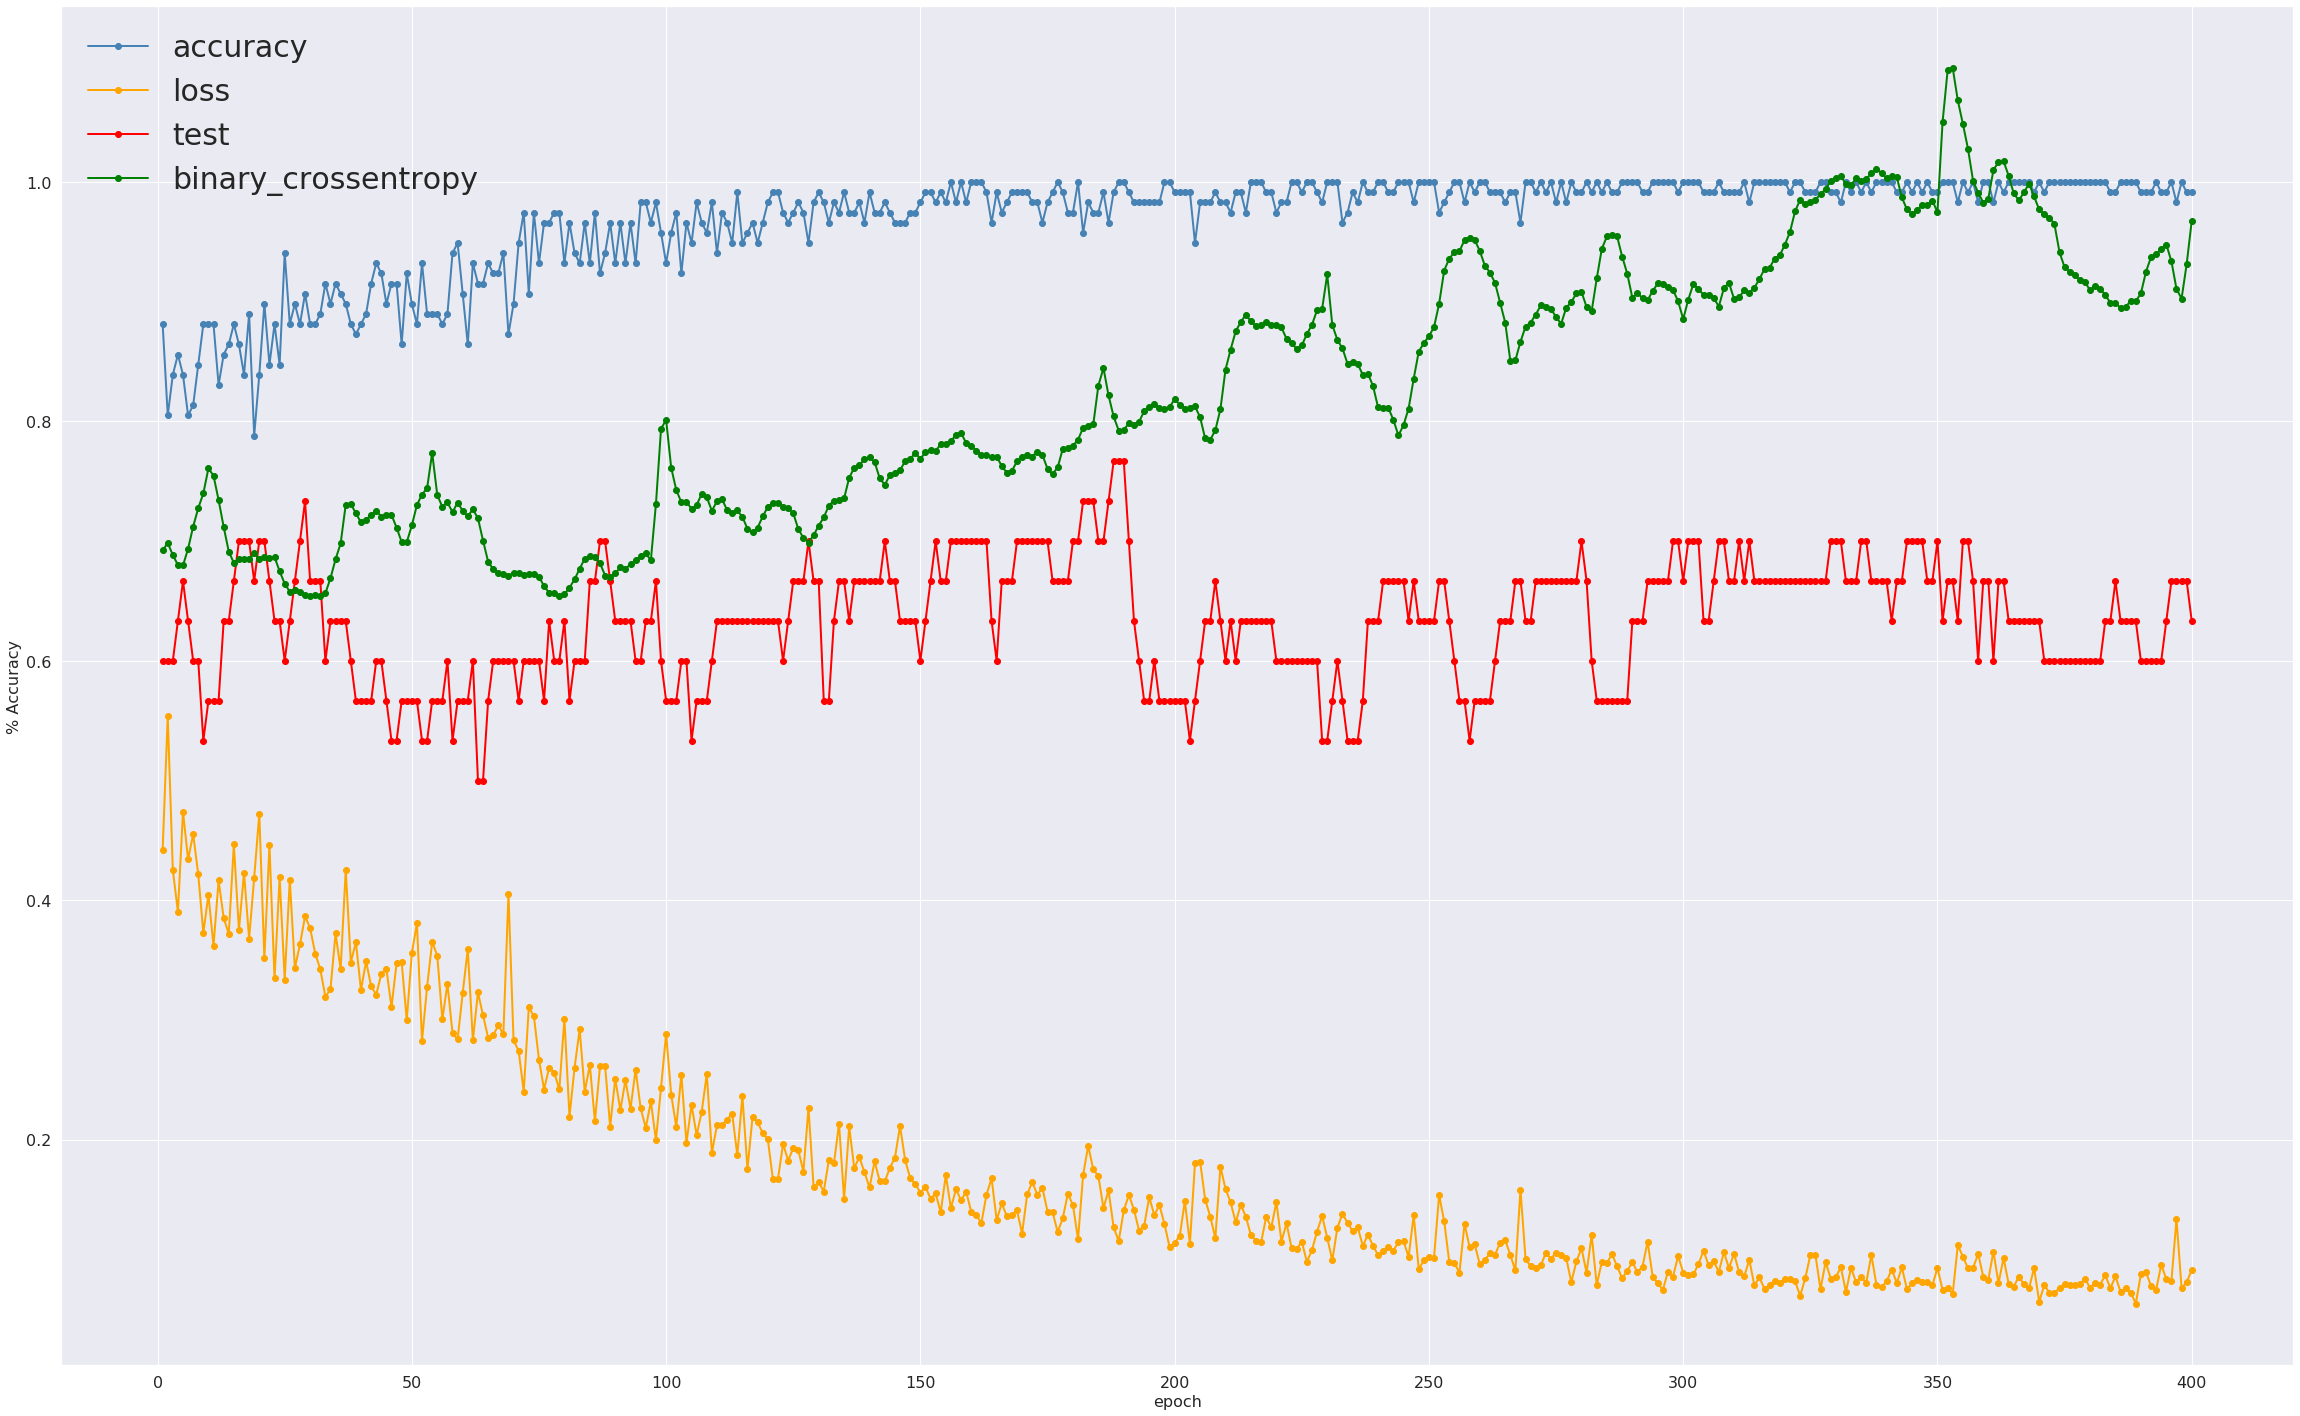

In [59]:
if run_3D_convnet:
    fig = plt.figure(figsize=(40, 25))
    epoch = np.arange(400) + 1
    fontsize = 16
    plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
             color="steelblue", label="accuracy")
    plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
             color="orange", label="loss")
    plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
         color="red", label="test")
    plt.plot(epoch, fit.history['val_binary_crossentropy'], marker="o", linewidth=2,
         color="green", label="binary_crossentropy")
    plt.xlabel('epoch', fontsize=fontsize)
    plt.ylabel('% Accuracy', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(frameon=False, fontsize=30);

In [60]:
# evaluate the model
scores = model.evaluate(testX, testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 63.33%


# PLOTTING

In [ ]:
SEQUENCES[20].shape

In [ ]:
plot_anat(BRAIN_BOXES[100], cmap='magma', colorbar=False, display_mode='ortho', annotate=False);

In [ ]:
B=nilearn.image.new_img_like(sequence_data,Rebounded_Sequence, affine=None, copy_header=False)

In [ ]:
plot_anat(BRAIN_BOXES[0], cmap='magma', colorbar=False, display_mode='ortho', annotate=False);

In [ ]:
A=nilearn.image.new_img_like(sequence_data, SEQUENCES[0], affine=None, copy_header=False)

In [ ]:
A.shape

In [ ]:


plot_anat(A, cmap='magma', colorbar=False, display_mode='ortho', annotate=False);



In [ ]:
plot_anat(sequence_data, cmap='magma', colorbar=False, display_mode='ortho', annotate=False);